In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import random
import logging
import multiprocessing
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import (Dataset, DataLoader)

from ctorch.config import ComplexTorchConfig
from ctorch.data_access import DataClass
from ctorch.model import UNet
from ctorch.evaluation import CustomEvaluation
from ctorch.utils import timing
from ctorch.utils.constants import (
    PROCESSED_DIR,
    TRAIN,
    VAL,
    TEST,
    INPUT,
    TARGET,
    HEIGHT,
    WIDTH,
    IN_CHANNELS,
    OUT_CHANNELS,
    HIDDEN_DIMENSIONS,
    PARAMETERS,
    CHECKPOINTS_DIR,
    ARTEFACTS,
    EPOCH,
    TRAIN_LOSS,
    VALID_LOSS,
    TRAIN_PSNR,
    TRAIN_PCC,
    TRAIN_SSIM,
    TRAIN_SCC,
    VALID_PSNR,
    VALID_PCC,
    VALID_SSIM,
    VALID_SCC,
    BEST_MODEL
)

PARENT_PATH = Path(os.getcwd()).parent.absolute()
device = "cuda" if torch.cuda.is_available() else "cpu"

FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)
logger = logging.getLogger(__name__)

# Seed everything
seed = 128
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Initialize data class for accessing data

In [3]:
config = ComplexTorchConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)

Initialize custom evaluation class for computing evaluation metrics

In [4]:
eval = CustomEvaluation()

#### Define torch model and custom dataset

Define Complex-UNet model

In [5]:
class Model(nn.Module):
    def __init__(self, config: ComplexTorchConfig):
        super().__init__()
        self.config = config
        self.params = self.config.MODEL_PARAMETERS
        H_difference = self.config.PREPROCESSING_NEW_HEIGHT - HEIGHT
        W_difference = self.config.PREPROCESSING_NEW_WIDTH - WIDTH
        self.pad = (
            round(W_difference / 2),
            W_difference - round(W_difference / 2),
            round(H_difference / 2),
            H_difference - round(H_difference / 2)
        )
        self.unet = UNet(
            in_channels=self.params[IN_CHANNELS],
            out_channels=self.params[OUT_CHANNELS],
            hidden_dims=self.params[HIDDEN_DIMENSIONS],
            pad=self.pad,
            **self.params[PARAMETERS]
        )

    def forward(self, x: torch.Tensor):
        return self.unet(x)

Define custom dataset for training model

In [6]:
class KSpaceDataset(Dataset):
    def __init__(self, input_path: Path, target_path: Path):
        super().__init__()
        self.input_path = input_path
        self.target_path = target_path
        self.files = sorted(os.listdir(self.input_path))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        X = np.load(os.path.join(self.input_path, file))
        Y = np.load(os.path.join(self.target_path, file))
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)
        return X, Y

#### Utility functions

Define utility function to create data loaders

In [7]:
def make_data_loader(
    input_path: Path,
    target_path: Path,
    batch_size: int,
    shuffle: bool = True,
    num_workers: int = 0
    ) -> DataLoader:
    data = KSpaceDataset(input_path=input_path, target_path=target_path)
    data_loader = DataLoader(
        dataset=data,
        batch_size = batch_size,
        shuffle = shuffle,
        num_workers=num_workers
    )
    return data_loader

Define utility function to obtain predictions from saved model

In [42]:
@timing
def infer(
    model: Model,
    loader: DataLoader
):
    input_eval = []
    output_eval = []
    # Move to device
    model.to(device)
    # Evaluation mode
    model.eval()
    with torch.no_grad():
        for i, (input, ground_truth) in enumerate(loader):
            # Move input to device
            input = input.to(device)
            ground_truth = ground_truth.to(device)
            # Forward pass
            residual = model(input)
            # Get prediction
            output = input + residual
            # Get evaluation scores
            input_eval.append(eval.compute_scores(
                input.detach().cpu().numpy(),
                ground_truth.detach().cpu().numpy()
            ))
            output_eval.append(eval.compute_scores(
                output.detach().cpu().numpy(),
                ground_truth.detach().cpu().numpy()
            ))
    return np.mean(input_eval, axis=0), np.mean(output_eval, axis=0)

#### Train and Validation Evaluation Scores

Load artefacts

In [17]:
artefacts = np.load(os.path.join(data.reports_path, ARTEFACTS))

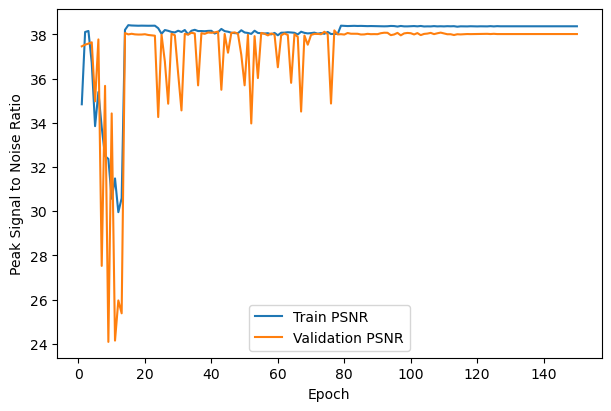

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, TRAIN_PSNR].reshape(-1,),
    ax=ax,
    label="Train PSNR"
)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, VALID_PSNR].reshape(-1,),
    ax=ax, label="Validation PSNR"
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Peak Signal to Noise Ratio")
plt.legend(loc="lower center");

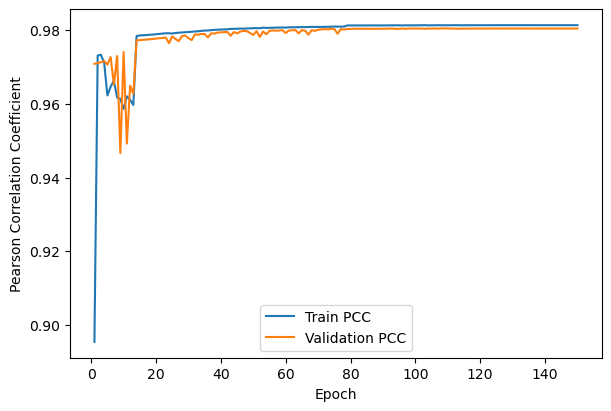

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, TRAIN_PCC].reshape(-1,),
    ax=ax,
    label="Train PCC"
)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, VALID_PCC].reshape(-1,),
    ax=ax, label="Validation PCC"
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Pearson Correlation Coefficient")
plt.legend(loc="lower center");

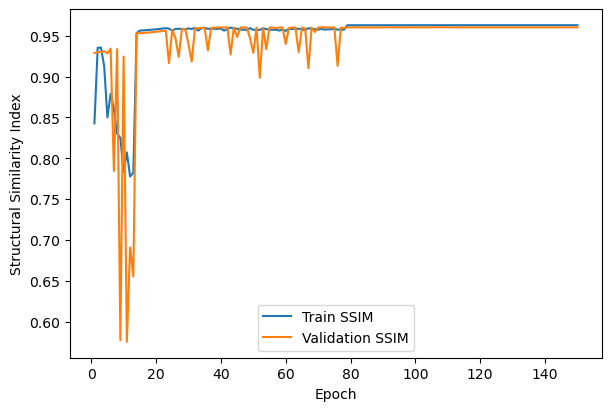

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, TRAIN_SSIM].reshape(-1,),
    ax=ax,
    label="Train SSIM"
)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, VALID_SSIM].reshape(-1,),
    ax=ax, label="Validation SSIM"
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Structural Similarity Index")
plt.legend(loc="lower center");

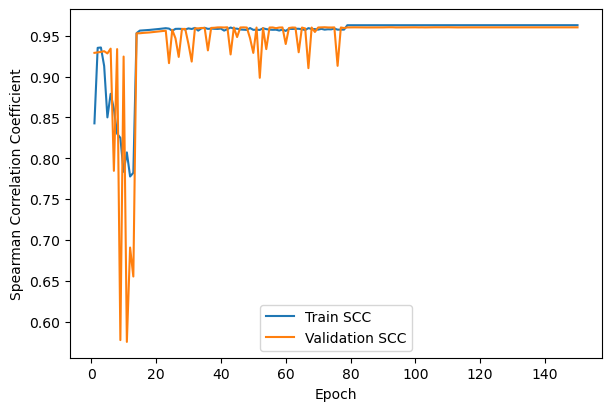

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, TRAIN_SSIM].reshape(-1,),
    ax=ax,
    label="Train SCC"
)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, VALID_SSIM].reshape(-1,),
    ax=ax, label="Validation SCC"
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Spearman Correlation Coefficient")
plt.legend(loc="lower center");

#### Inference on Test dataset

##### Build test data loader

In [24]:
BATCH_SIZE = 1
NUM_WORKERS = max(0, multiprocessing.cpu_count() - 2)

test_input_path = os.path.join(data.data_path, PROCESSED_DIR, TEST, INPUT)
test_target_path = os.path.join(data.data_path, PROCESSED_DIR, TEST, TARGET)
test_loader = make_data_loader(
    input_path=test_input_path,
    target_path=test_target_path,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)
logger.info(f"Number of test samples: {len(test_loader.dataset)}")

2023-01-06 14:12:36,622 - __main__ - INFO - Number of test samples: 1008


##### Load pre-trained best model

In [31]:
model = Model(config)

checkpoint_path = Path(os.path.join(data.current_path, CHECKPOINTS_DIR))
checkpoint = torch.load(os.path.join(checkpoint_path, BEST_MODEL), map_location="cpu")
model.load_state_dict(checkpoint["model"])
logger.info(f"Loaded {os.path.join(checkpoint_path, BEST_MODEL)}")

2023-01-06 14:18:56,281 - __main__ - INFO - Loaded /home/vtyagi/repos/MRI-Denoising/checkpoints/best_model.pt


##### Predict on Test dataset and compute evaluation metrics

In [43]:
input_eval, output_eval = \
    infer(
        model=model,
        loader=test_loader,
    )

2023-01-06 14:26:29,874 - ctorch.utils.utils - INFO - func:infer took: 2 min and 21.72 sec


In [47]:
print(f"PSNR between input and ground truth: {input_eval[0]}")
print(f"PSNR between predicted and ground truth: {output_eval[0]}")
print(f"\nPCC between input and ground truth: {input_eval[1]}")
print(f"PCC between predicted and ground truth: {output_eval[1]}")
print(f"\nSSIM between input and ground truth: {input_eval[2]}")
print(f"SSIM between predicted and ground truth: {output_eval[2]}")
print(f"\nSCC between input and ground truth: {input_eval[3]}")
print(f"SCC between predicted and ground truth: {output_eval[3]}")

PSNR between input and ground truth: 37.480050609273256
PSNR between predicted and ground truth: 38.01355908386011

PCC between input and ground truth: 0.9726127668366039
PCC between predicted and ground truth: 0.9804462511803352

SSIM between input and ground truth: 0.9346138440044626
SSIM between predicted and ground truth: 0.9617990226755596

SCC between input and ground truth: 0.8738421988008863
SCC between predicted and ground truth: 0.8962119049978373


We see increase in similarity scores between predicted and ground truth.

Hence, the predicted MR images are closer to ground truth than input images on the **test** dataset. This validates the performance of our model.